In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import (
    shuffle as sk_shuffle,
)

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [9]:
def generate_kernel_parameters(X_ref, kernelType, M_order):
    """
    Generates parameters (centers mu, width s) for Gaussian/Sigmoidal kernels.
    X_ref: Reference data (1D array, typically X_train) to determine range for mu.
    kernelType: 'gaussian' or 'sigmoidal'.
    M_order: Number of basis functions (e.g., Gaussians or sigmoids).
    """
    params = {}
    if kernelType == "gaussian" or kernelType == "sigmoidal":
        if len(X_ref) == 0:
            # Fallback if X_ref is empty
            params["mu"] = np.zeros(M_order) if M_order > 0 else []
            params["s"] = 0.1
            return params

        min_x, max_x = np.min(X_ref), np.max(X_ref)

        if M_order > 0:
            if min_x == max_x:  # All points in X_ref are the same
                params["mu"] = np.full(M_order, min_x)
            else:
                params["mu"] = np.linspace(min_x, max_x, M_order)
        else:  # M_order is 0
            params["mu"] = []

        if M_order > 1 and min_x != max_x:
            params["s"] = (max_x - min_x) / M_order
        elif M_order == 1 and min_x != max_x:
            params["s"] = (max_x - min_x) / 2.0 if (max_x - min_x) > 0 else 0.1
        else:  # M_order is 0, or M_order >=1 but min_x == max_x
            params["s"] = 0.1  # Default small s

        if params["s"] == 0:  # Ensure s is not zero to avoid division by zero
            params["s"] = 0.1
    return params

def transform_features(X_input, kernelType, M_order, kernel_params):
    """
    Transforms raw 1D input X_input into a design matrix Phi.
    X_input: 1D numpy array of input samples.
    kernelType: 'polynomial', 'gaussian', or 'sigmoidal'.
    M_order: Polynomial degree or number of Gaussian/Sigmoidal basis functions.
    kernel_params: Dictionary containing 'mu' and 's' for Gaussian/Sigmoidal.
    Returns: Design matrix Phi (N_samples, M_order + 1).
    """
    X_input = np.asarray(X_input).flatten()  # Ensure X_input is 1D
    N = len(X_input)

    if kernelType == "polynomial":
        Phi = np.zeros((N, M_order + 1))
        for i in range(M_order + 1):
            Phi[:, i] = X_input**i
    elif kernelType == "gaussian":
        Phi = np.zeros((N, M_order + 1))
        Phi[:, 0] = 1  # Bias term
        if M_order > 0:
            mu = kernel_params["mu"]
            s = kernel_params["s"]
            for j in range(M_order):
                Phi[:, j + 1] = np.exp(-((X_input - mu[j]) ** 2) / (2 * s**2))
    elif kernelType == "sigmoidal":
        Phi = np.zeros((N, M_order + 1))
        Phi[:, 0] = 1  # Bias term
        if M_order > 0:
            mu = kernel_params["mu"]
            s = kernel_params["s"]
            for j in range(M_order):
                Phi[:, j + 1] = sigmoid((X_input - mu[j]) / s)
    else:
        raise ValueError(f"Unknown kernel type: {kernelType}")
    return Phi

In [10]:

def ErrorPred(w_est, X_train, Y_train, X_test, Y_test, kernelType):
    """
    (estimated weight, training data, training targets, testing data, testing targets, type of the kernel )
    Computes and returns the train and test Mean Squared Errors (MSE).
    """
    M = len(w_est) - 1  # M_order (degree or number of basis functions)
    kernel_params = generate_kernel_parameters(X_train, kernelType, M)
    Phi_train = transform_features(X_train, kernelType, M, kernel_params)
    Phi_test = transform_features(X_test, kernelType, M, kernel_params)
    Y_train_pred = Phi_train @ w_est
    Y_test_pred = Phi_test @ w_est
    TrainError = np.mean((Y_train.flatten() - Y_train_pred.flatten()) ** 2)
    TestError = np.mean((Y_test.flatten() - Y_test_pred.flatten()) ** 2)

    return TrainError, TestError

In [11]:

def Training(
    X_train, Y_train, X_test, Y_test, kernelType, M_order, Epochs, BatchSize, stepSize
):
    """
    (training data, training targets, testing data, testing targets,
     type of the kernel, order of the model, Number of epochs, Batch size, Step size)
    Returns the estimated weights and histories of train/test errors.
    """
    N_train = len(X_train)

    # Initialize weights (M_order + 1 for bias)
    weights = np.random.randn(M_order + 1) * 0.01

    # Generate kernel parameters ONCE based on the full X_train
    kernel_params_sgd = generate_kernel_parameters(X_train, kernelType, M_order)

    train_errors_per_epoch = []
    test_errors_per_epoch = []

    print(
        f"Starting training: Kernel={kernelType}, M={M_order}, Epochs={Epochs}, BatchSize={BatchSize}, StepSize={stepSize}"
    )

    for epoch in range(Epochs):
        X_train_shuffled, Y_train_shuffled = sk_shuffle(
            X_train, Y_train, random_state=epoch
        )

        num_batches = N_train // BatchSize
        if N_train % BatchSize != 0:
            num_batches += 1

        for i in range(num_batches):
            start_idx = i * BatchSize
            end_idx = min((i + 1) * BatchSize, N_train)
            X_batch = X_train_shuffled[start_idx:end_idx]
            Y_batch = Y_train_shuffled[start_idx:end_idx]

            if len(X_batch) == 0:
                continue

            batch_gradient_sum = np.zeros_like(weights)

            for n in range(len(X_batch)):
                x_n = X_batch[n]
                y_n = Y_batch[n]
                phi_n = transform_features(
                    np.array([x_n]), kernelType, M_order, kernel_params_sgd
                )[0]
                y_pred_n = phi_n @ weights
                grad_n = 2 * (y_pred_n - y_n) * phi_n
                batch_gradient_sum += grad_n

            mean_batch_gradient = batch_gradient_sum / len(X_batch)
            weights -= stepSize * mean_batch_gradient

        current_train_error, current_test_error = ErrorPred(
            weights, X_train, Y_train, X_test, Y_test, kernelType
        )
        train_errors_per_epoch.append(current_train_error)
        test_errors_per_epoch.append(current_test_error)

        if (epoch + 1) % (Epochs // 10 if Epochs >= 10 else 1) == 0:
            print(
                f"Epoch {epoch+1}/{Epochs} - Train MSE: {current_train_error:.4f}, Test MSE: {current_test_error:.4f}"
            )

    # Plot training and testing error across the epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(Epochs), train_errors_per_epoch, label="Training MSE")
    plt.plot(range(Epochs), test_errors_per_epoch, label="Testing MSE")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title(
        f"MSE vs. Epochs for {kernelType} (M={M_order}, BS={BatchSize}, LR={stepSize})"
    )
    plt.legend()
    plt.grid(True)
    plt.show()

    return weights, train_errors_per_epoch, test_errors_per_epoch

In [12]:

def Pred(w_est, X_train, X_test, kernelType):
    """
    (estimated weights, training data, testing data, type of the kernel )
    Computes and returns the training and testing target estimates.
    """
    M = len(w_est) - 1  # M_order
    kernel_params = generate_kernel_parameters(X_train, kernelType, M)

    Phi_train = transform_features(X_train, kernelType, M, kernel_params)
    Phi_test = transform_features(X_test, kernelType, M, kernel_params)

    Y_train_pred = Phi_train @ w_est
    Y_test_pred = Phi_test @ w_est

    return Y_train_pred, Y_test_pred


def Pred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType):
    """
    (estimated weights, training data, training targets, testing data, testing targets, type of the kernel )
    Computes and returns the training and testing errors (MSE).
    """
    return ErrorPred(w_est, X_train, Y_train, X_test, Y_test, kernelType)

In [13]:

def generate_data_3a(num_points=100, noise_std=0.1):
    """Generates data for Part 3(a): t_n = sin(2*pi*x_n) + e_n"""
    X = np.random.rand(num_points, 1)
    e = np.random.normal(0, noise_std, (num_points, 1))
    T = np.sin(2 * np.pi * X) + e
    return X.flatten(), T.flatten()


def generate_data_3b(num_points_total=100, noise_std=0.1):
    """Generates data for Part 3(b): piecewise function"""
    num_points_per_segment = num_points_total // 3
    X_segments, T_segments = [], []

    X1 = np.random.uniform(0, 1, num_points_per_segment)
    T1 = np.sin(2 * np.pi * X1)
    X_segments.append(X1)
    T_segments.append(T1)

    X2 = np.random.uniform(1, 2, num_points_per_segment)
    T2 = 2 * (0.5 - np.abs(X2 - 1.5))
    X_segments.append(X2)
    T_segments.append(T2)

    num_points_s3 = num_points_total - 2 * num_points_per_segment
    X3 = np.random.uniform(2, 3, num_points_s3)
    T3 = np.exp(-((X3 - 2.5) ** 2) / (2 * 0.1**2))
    X_segments.append(X3)
    T_segments.append(T3)

    X = np.concatenate(X_segments)
    T_true = np.concatenate(T_segments)
    e = np.random.normal(0, noise_std, X.shape[0])
    T = T_true + e

    sorted_indices = np.argsort(X)
    X = X[sorted_indices]
    T = T[sorted_indices]

    return X.flatten(), T.flatten()

In [14]:

M_common = 5  # Order of model (polynomial degree or num basis functions)
Epochs_common = 200
BatchSize_common = 10
StepSize_common = 0.01

kernel_colors = {"polynomial": "blue", "gaussian": "green", "sigmoidal": "red"}

----------------------------------------------------
Part 4(a): Repeating 3(a) with SGD
----------------------------------------------------

--- Data from 3(a) ---

Training for 3(a) data with polynomial kernel:
Starting training: Kernel=polynomial, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: 0.3802, Test MSE: 0.3246
Epoch 40/200 - Train MSE: 0.3069, Test MSE: 0.2762
Epoch 60/200 - Train MSE: 0.2746, Test MSE: 0.2658
Epoch 80/200 - Train MSE: 0.2593, Test MSE: 0.2673
Epoch 100/200 - Train MSE: 0.2511, Test MSE: 0.2706
Epoch 120/200 - Train MSE: 0.2460, Test MSE: 0.2731
Epoch 140/200 - Train MSE: 0.2422, Test MSE: 0.2739
Epoch 160/200 - Train MSE: 0.2391, Test MSE: 0.2736
Epoch 180/200 - Train MSE: 0.2363, Test MSE: 0.2724
Epoch 200/200 - Train MSE: 0.2337, Test MSE: 0.2706


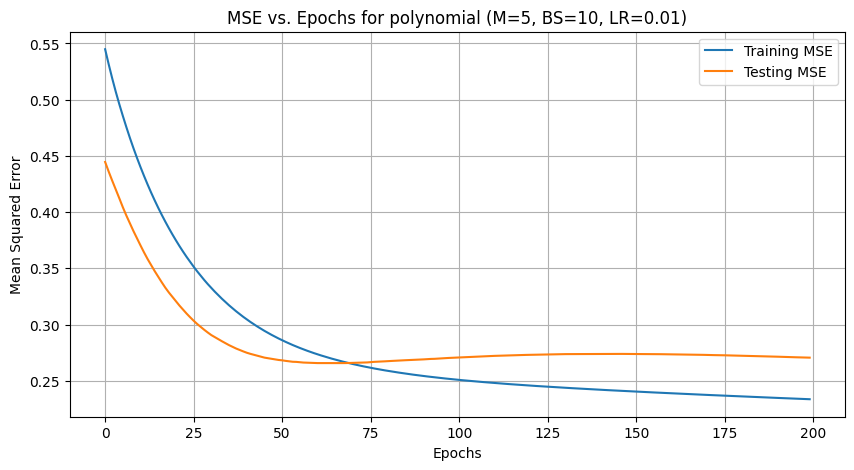

Final MSE for polynomial (3a data) - Train: 0.2337, Test: 0.2706


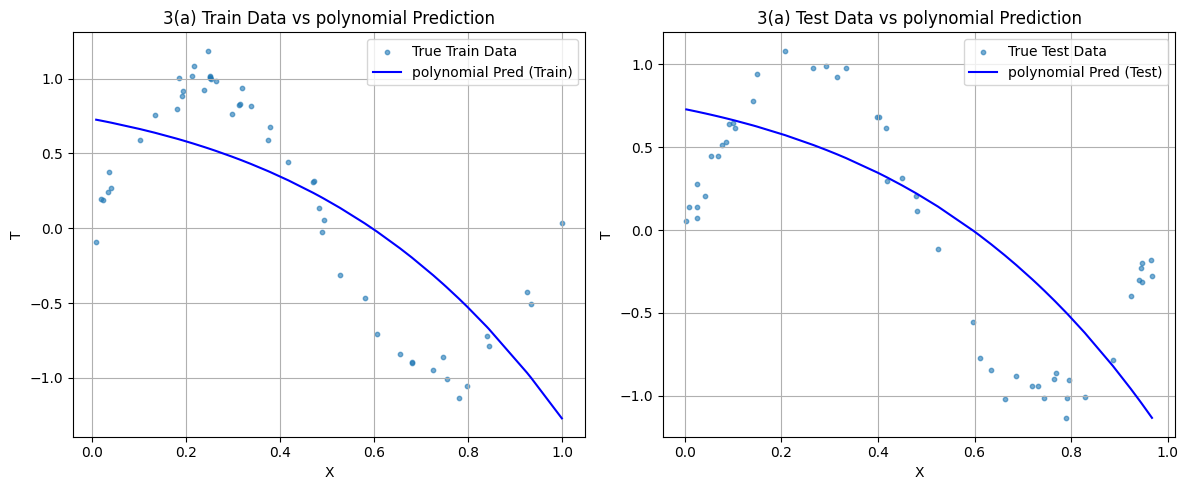


Training for 3(a) data with gaussian kernel:
Starting training: Kernel=gaussian, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: 0.1625, Test MSE: 0.1618
Epoch 40/200 - Train MSE: 0.0864, Test MSE: 0.0959
Epoch 60/200 - Train MSE: 0.0633, Test MSE: 0.0796
Epoch 80/200 - Train MSE: 0.0530, Test MSE: 0.0720
Epoch 100/200 - Train MSE: 0.0465, Test MSE: 0.0658
Epoch 120/200 - Train MSE: 0.0414, Test MSE: 0.0601
Epoch 140/200 - Train MSE: 0.0373, Test MSE: 0.0548
Epoch 160/200 - Train MSE: 0.0338, Test MSE: 0.0500
Epoch 180/200 - Train MSE: 0.0308, Test MSE: 0.0457
Epoch 200/200 - Train MSE: 0.0281, Test MSE: 0.0418


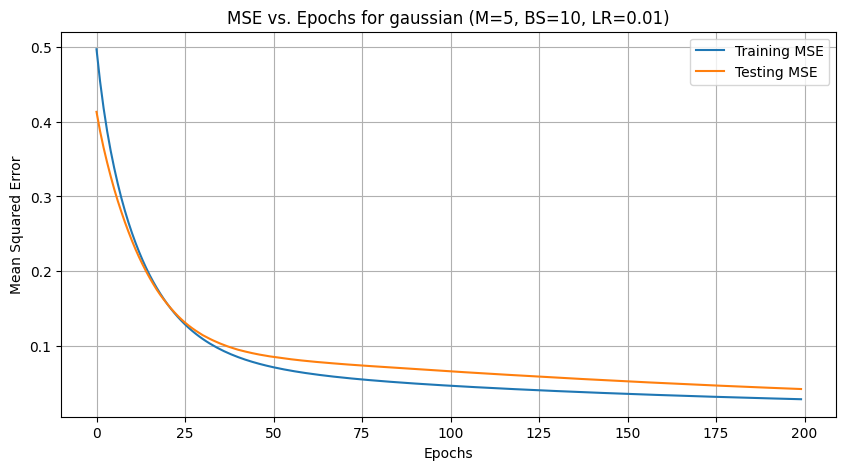

Final MSE for gaussian (3a data) - Train: 0.0281, Test: 0.0418


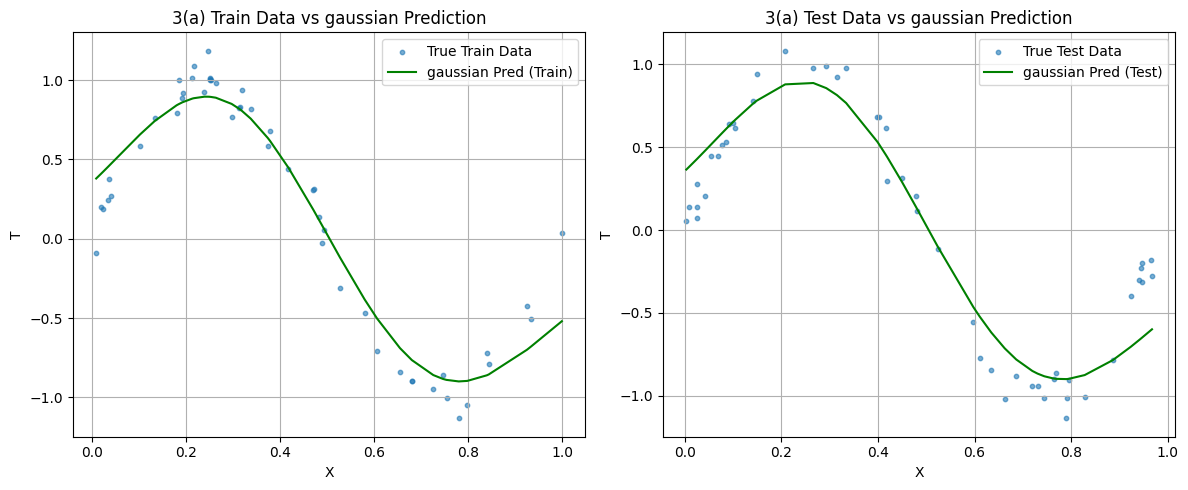


Training for 3(a) data with sigmoidal kernel:
Starting training: Kernel=sigmoidal, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: 0.4151, Test MSE: 0.3635
Epoch 40/200 - Train MSE: 0.3269, Test MSE: 0.2819
Epoch 60/200 - Train MSE: 0.2723, Test MSE: 0.2386
Epoch 80/200 - Train MSE: 0.2384, Test MSE: 0.2177
Epoch 100/200 - Train MSE: 0.2172, Test MSE: 0.2078
Epoch 120/200 - Train MSE: 0.2039, Test MSE: 0.2045
Epoch 140/200 - Train MSE: 0.1954, Test MSE: 0.2045
Epoch 160/200 - Train MSE: 0.1899, Test MSE: 0.2064
Epoch 180/200 - Train MSE: 0.1863, Test MSE: 0.2086
Epoch 200/200 - Train MSE: 0.1838, Test MSE: 0.2111


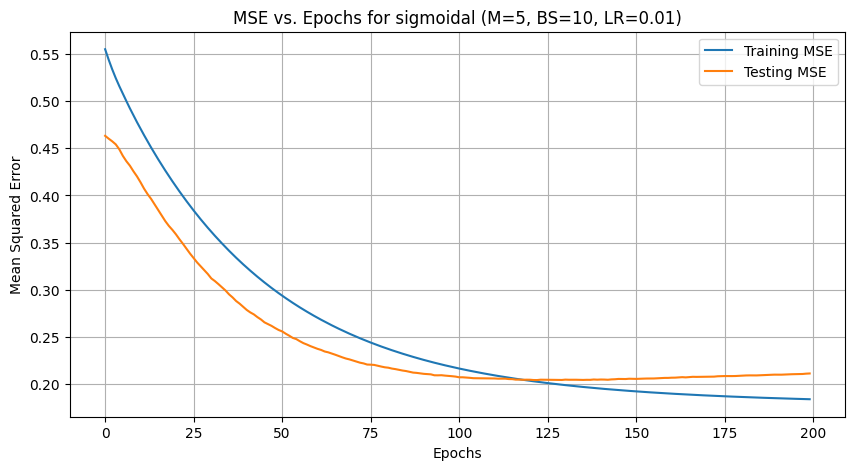

Final MSE for sigmoidal (3a data) - Train: 0.1838, Test: 0.2111


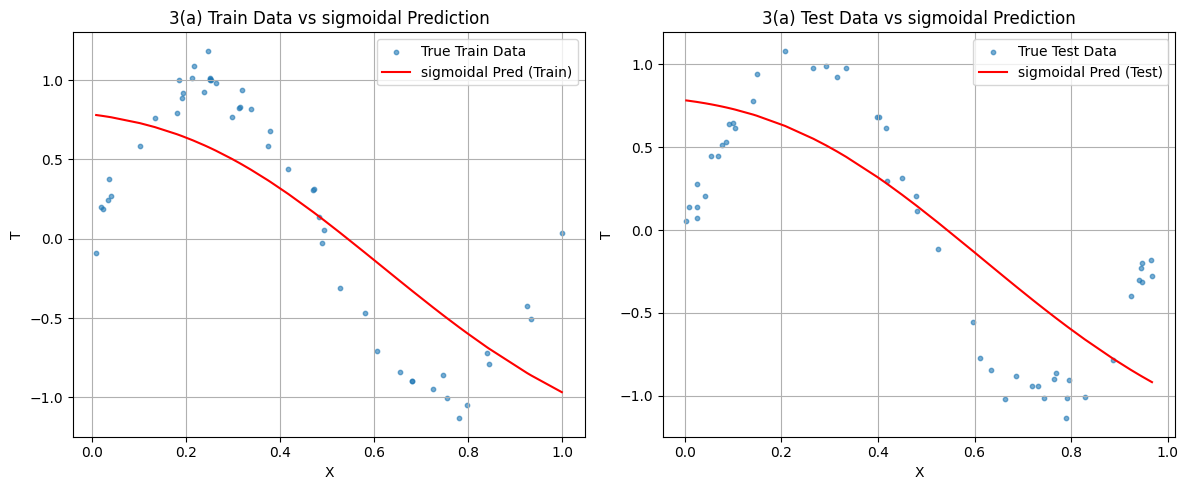

In [15]:

print("----------------------------------------------------")
print("Part 4(a): Repeating 3(a) with SGD")
print("----------------------------------------------------")

print("\n--- Data from 3(a) ---")
X_3a, T_3a = generate_data_3a(num_points=100)
X_train_3a, X_test_3a, Y_train_3a, Y_test_3a = train_test_split(
    X_3a, T_3a, test_size=0.5, random_state=42
)

results_3a = {}
for kernel in ["polynomial", "gaussian", "sigmoidal"]:
    print(f"\nTraining for 3(a) data with {kernel} kernel:")
    w_est_3a, _, _ = Training(
        X_train_3a,
        Y_train_3a,
        X_test_3a,
        Y_test_3a,
        kernel,
        M_common,
        Epochs_common,
        BatchSize_common,
        StepSize_common,
    )

    final_train_err, final_test_err = Pred_Error(
        w_est_3a, X_train_3a, Y_train_3a, X_test_3a, Y_test_3a, kernel
    )
    print(
        f"Final MSE for {kernel} (3a data) - Train: {final_train_err:.4f}, Test: {final_test_err:.4f}"
    )

    Y_pred_train_3a, Y_pred_test_3a = Pred(w_est_3a, X_train_3a, X_test_3a, kernel)
    results_3a[kernel] = {
        "weights": w_est_3a,
        "train_err": final_train_err,
        "test_err": final_test_err,
        "Y_pred_train": Y_pred_train_3a,
        "Y_pred_test": Y_pred_test_3a,
    }

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sort_idx_train = np.argsort(X_train_3a)
    plt.scatter(
        X_train_3a[sort_idx_train],
        Y_train_3a[sort_idx_train],
        label="True Train Data",
        alpha=0.6,
        s=10,
    )
    plt.plot(
        X_train_3a[sort_idx_train],
        Y_pred_train_3a[sort_idx_train],
        color=kernel_colors[kernel],
        label=f"{kernel} Pred (Train)",
    )
    plt.title(f"3(a) Train Data vs {kernel} Prediction")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sort_idx_test = np.argsort(X_test_3a)
    plt.scatter(
        X_test_3a[sort_idx_test],
        Y_test_3a[sort_idx_test],
        label="True Test Data",
        alpha=0.6,
        s=10,
    )
    plt.plot(
        X_test_3a[sort_idx_test],
        Y_pred_test_3a[sort_idx_test],
        color=kernel_colors[kernel],
        label=f"{kernel} Pred (Test)",
    )
    plt.title(f"3(a) Test Data vs {kernel} Prediction")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


----------------------------------------------------
Part 4(a): Repeating 3(b) with SGD
----------------------------------------------------

--- Data from 3(b) ---

Training for 3(b) data with polynomial kernel:
Starting training: Kernel=polynomial, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: nan, Test MSE: nan
Epoch 40/200 - Train MSE: nan, Test MSE: nan
Epoch 60/200 - Train MSE: nan, Test MSE: nan
Epoch 80/200 - Train MSE: nan, Test MSE: nan


/tmp/ipykernel_18335/2718400007.py:12: RuntimeWarning: overflow encountered in square
  TrainError = np.mean((Y_train.flatten() - Y_train_pred.flatten()) ** 2)
/tmp/ipykernel_18335/2718400007.py:13: RuntimeWarning: overflow encountered in square
  TestError = np.mean((Y_test.flatten() - Y_test_pred.flatten()) ** 2)
/tmp/ipykernel_18335/2307710257.py:52: RuntimeWarning: overflow encountered in add
  batch_gradient_sum += grad_n
/tmp/ipykernel_18335/2307710257.py:55: RuntimeWarning: invalid value encountered in subtract
  weights -= stepSize * mean_batch_gradient


Epoch 100/200 - Train MSE: nan, Test MSE: nan
Epoch 120/200 - Train MSE: nan, Test MSE: nan
Epoch 140/200 - Train MSE: nan, Test MSE: nan
Epoch 160/200 - Train MSE: nan, Test MSE: nan
Epoch 180/200 - Train MSE: nan, Test MSE: nan
Epoch 200/200 - Train MSE: nan, Test MSE: nan


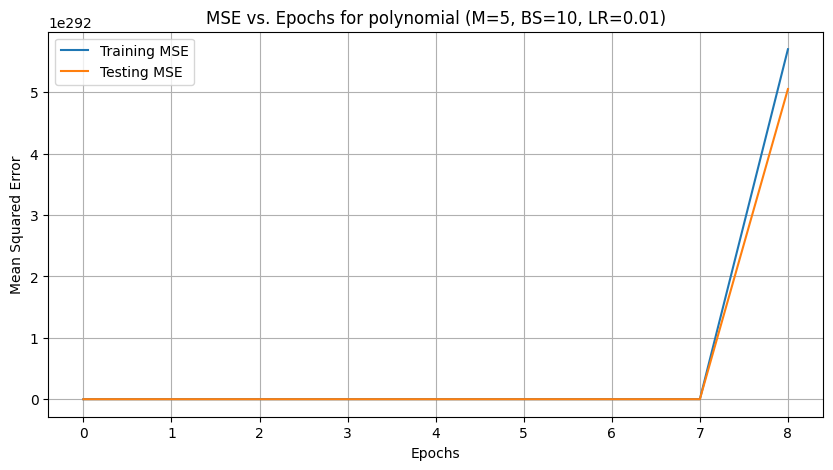

Final MSE for polynomial (3b data) - Train: nan, Test: nan


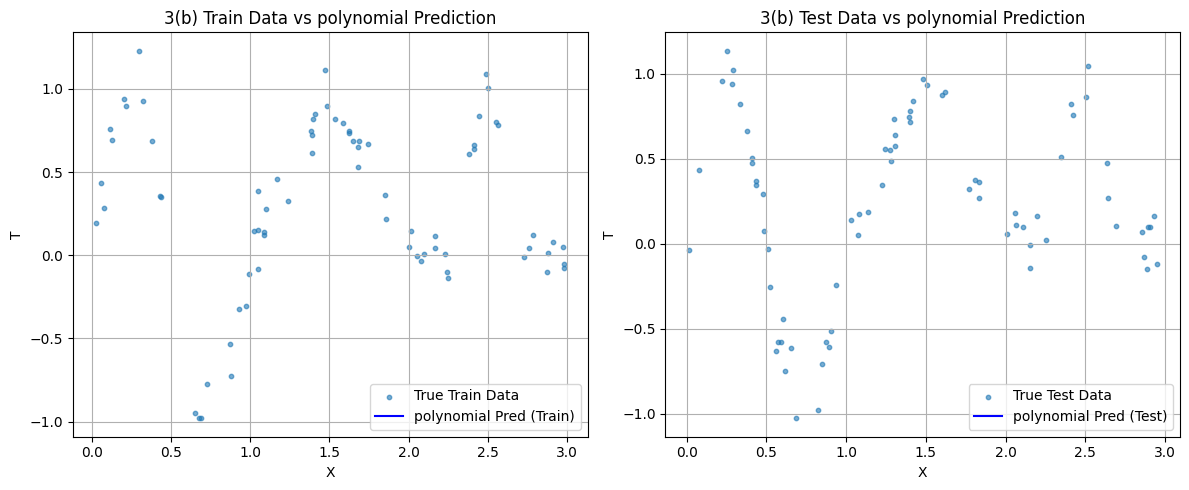


Training for 3(b) data with gaussian kernel:
Starting training: Kernel=gaussian, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: 0.2400, Test MSE: 0.2573
Epoch 40/200 - Train MSE: 0.2308, Test MSE: 0.2480
Epoch 60/200 - Train MSE: 0.2234, Test MSE: 0.2389
Epoch 80/200 - Train MSE: 0.2171, Test MSE: 0.2318
Epoch 100/200 - Train MSE: 0.2118, Test MSE: 0.2259
Epoch 120/200 - Train MSE: 0.2073, Test MSE: 0.2210
Epoch 140/200 - Train MSE: 0.2034, Test MSE: 0.2170
Epoch 160/200 - Train MSE: 0.2001, Test MSE: 0.2135
Epoch 180/200 - Train MSE: 0.1971, Test MSE: 0.2097
Epoch 200/200 - Train MSE: 0.1945, Test MSE: 0.2067


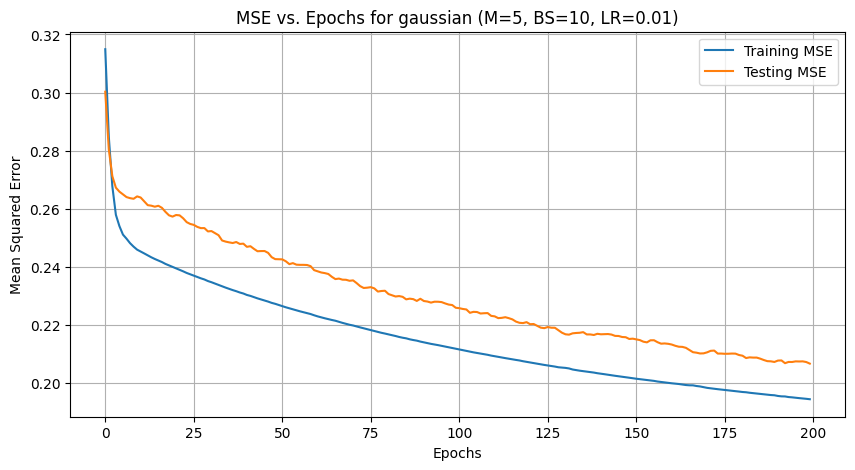

Final MSE for gaussian (3b data) - Train: 0.1945, Test: 0.2067


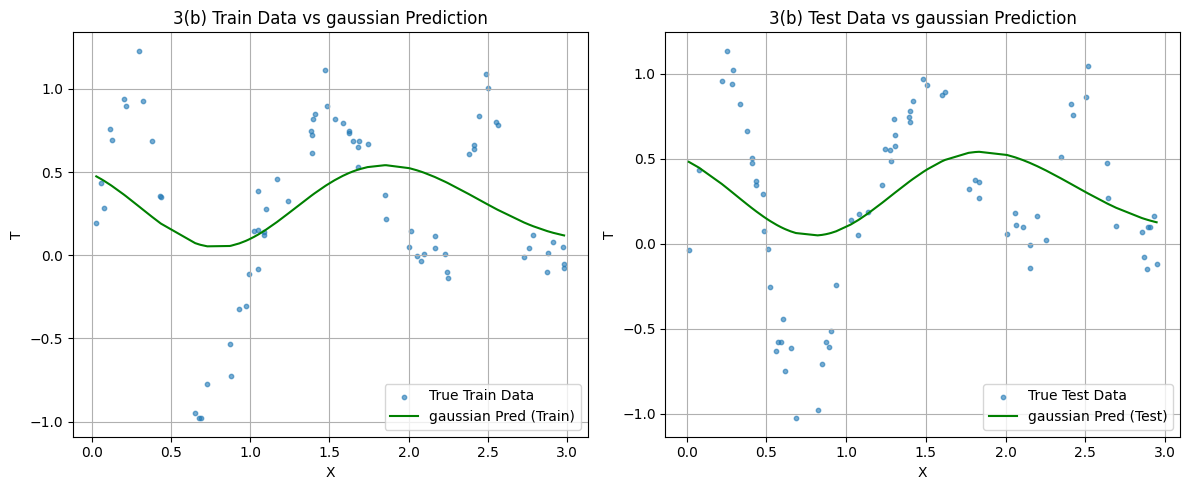


Training for 3(b) data with sigmoidal kernel:
Starting training: Kernel=sigmoidal, M=5, Epochs=200, BatchSize=10, StepSize=0.01
Epoch 20/200 - Train MSE: 0.2552, Test MSE: 0.2715
Epoch 40/200 - Train MSE: 0.2542, Test MSE: 0.2745
Epoch 60/200 - Train MSE: 0.2536, Test MSE: 0.2732
Epoch 80/200 - Train MSE: 0.2533, Test MSE: 0.2748
Epoch 100/200 - Train MSE: 0.2531, Test MSE: 0.2729
Epoch 120/200 - Train MSE: 0.2527, Test MSE: 0.2741
Epoch 140/200 - Train MSE: 0.2524, Test MSE: 0.2738
Epoch 160/200 - Train MSE: 0.2521, Test MSE: 0.2746
Epoch 180/200 - Train MSE: 0.2519, Test MSE: 0.2745
Epoch 200/200 - Train MSE: 0.2516, Test MSE: 0.2736


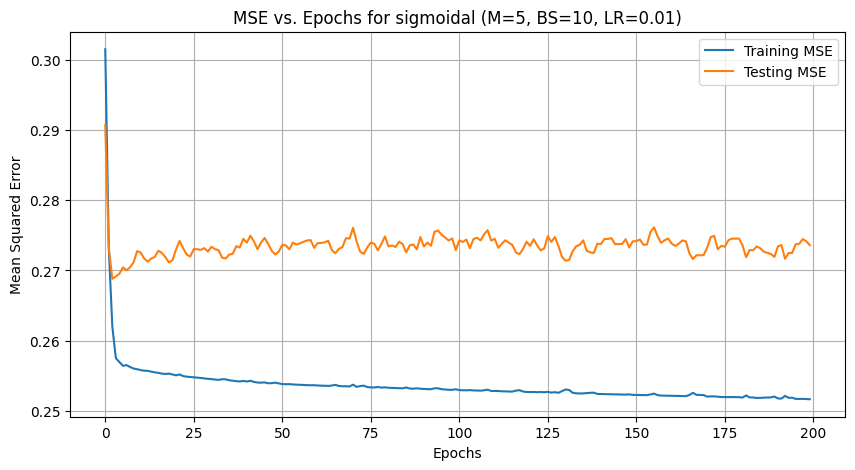

Final MSE for sigmoidal (3b data) - Train: 0.2516, Test: 0.2736


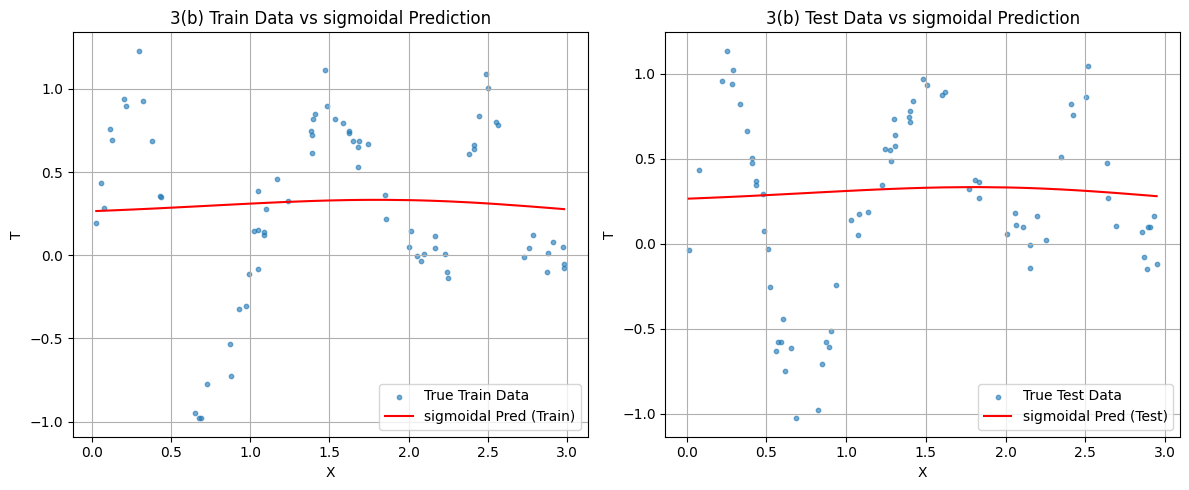

In [16]:

print("\n----------------------------------------------------")
print("Part 4(a): Repeating 3(b) with SGD")
print("----------------------------------------------------")

print("\n--- Data from 3(b) ---")
X_3b, T_3b = generate_data_3b(num_points_total=150)
X_train_3b, X_test_3b, Y_train_3b, Y_test_3b = train_test_split(
    X_3b, T_3b, test_size=0.5, random_state=42
)

results_3b = {}
for kernel in ["polynomial", "gaussian", "sigmoidal"]:
    print(f"\nTraining for 3(b) data with {kernel} kernel:")
    w_est_3b, _, _ = Training(
        X_train_3b,
        Y_train_3b,
        X_test_3b,
        Y_test_3b,
        kernel,
        M_common,
        Epochs_common,
        BatchSize_common,
        StepSize_common,
    )

    final_train_err, final_test_err = Pred_Error(
        w_est_3b, X_train_3b, Y_train_3b, X_test_3b, Y_test_3b, kernel
    )
    print(
        f"Final MSE for {kernel} (3b data) - Train: {final_train_err:.4f}, Test: {final_test_err:.4f}"
    )

    Y_pred_train_3b, Y_pred_test_3b = Pred(w_est_3b, X_train_3b, X_test_3b, kernel)
    results_3b[kernel] = {
        "weights": w_est_3b,
        "train_err": final_train_err,
        "test_err": final_test_err,
        "Y_pred_train": Y_pred_train_3b,
        "Y_pred_test": Y_pred_test_3b,
    }

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sort_idx_train = np.argsort(X_train_3b)
    plt.scatter(
        X_train_3b[sort_idx_train],
        Y_train_3b[sort_idx_train],
        label="True Train Data",
        alpha=0.6,
        s=10,
    )
    plt.plot(
        X_train_3b[sort_idx_train],
        Y_pred_train_3b[sort_idx_train],
        color=kernel_colors[kernel],
        label=f"{kernel} Pred (Train)",
    )
    plt.title(f"3(b) Train Data vs {kernel} Prediction")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sort_idx_test = np.argsort(X_test_3b)
    plt.scatter(
        X_test_3b[sort_idx_test],
        Y_test_3b[sort_idx_test],
        label="True Test Data",
        alpha=0.6,
        s=10,
    )
    plt.plot(
        X_test_3b[sort_idx_test],
        Y_pred_test_3b[sort_idx_test],
        color=kernel_colors[kernel],
        label=f"{kernel} Pred (Test)",
    )
    plt.title(f"3(b) Test Data vs {kernel} Prediction")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


----------------------------------------------------
Part 4(a): Study the effect of stepSize
----------------------------------------------------

Training with stepSize = 0.1 (Kernel: gaussian, Data: 3a)
LR=0.1, Epoch 20, Test MSE: 0.0413
LR=0.1, Epoch 40, Test MSE: 0.0200
LR=0.1, Epoch 60, Test MSE: 0.0136
LR=0.1, Epoch 80, Test MSE: 0.0114
LR=0.1, Epoch 100, Test MSE: 0.0100
LR=0.1, Epoch 120, Test MSE: 0.0099
LR=0.1, Epoch 140, Test MSE: 0.0095
LR=0.1, Epoch 160, Test MSE: 0.0097
LR=0.1, Epoch 180, Test MSE: 0.0104
LR=0.1, Epoch 200, Test MSE: 0.0093

Training with stepSize = 0.01 (Kernel: gaussian, Data: 3a)
LR=0.01, Epoch 20, Test MSE: 0.1678
LR=0.01, Epoch 40, Test MSE: 0.0972
LR=0.01, Epoch 60, Test MSE: 0.0801
LR=0.01, Epoch 80, Test MSE: 0.0724
LR=0.01, Epoch 100, Test MSE: 0.0663
LR=0.01, Epoch 120, Test MSE: 0.0605
LR=0.01, Epoch 140, Test MSE: 0.0552
LR=0.01, Epoch 160, Test MSE: 0.0503
LR=0.01, Epoch 180, Test MSE: 0.0460
LR=0.01, Epoch 200, Test MSE: 0.0421

Training wi

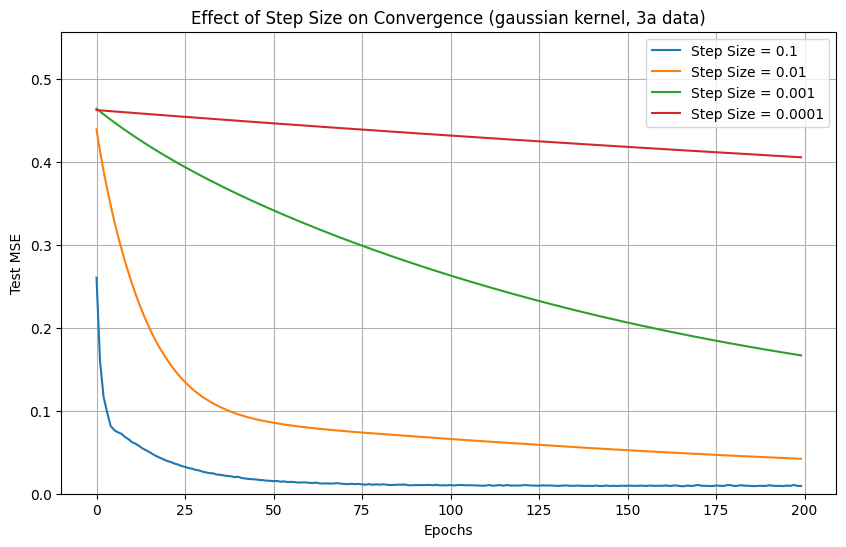

In [17]:
print("\n----------------------------------------------------")
print("Part 4(a): Study the effect of stepSize")
print("----------------------------------------------------")

kernel_for_lr_study = "gaussian"  # Using Gaussian kernel and 3(a) data as example
step_sizes_to_test = [0.1, 0.01, 0.001, 0.0001]
lr_study_results_test_mse = {}

for lr in step_sizes_to_test:
    print(f"\nTraining with stepSize = {lr} (Kernel: {kernel_for_lr_study}, Data: 3a)")
    # For this study, we only need the error history, so we call Training and use its returned history
    # We suppress the individual plots from Training by modifying it or just focusing on its returned values

    # Re-using X_train_3a, Y_train_3a, X_test_3a, Y_test_3a
    # The Training function already plots, but if we want a combined plot, we'd need to capture histories

    # Simplified Training loop to capture history for this specific study (without individual plots)
    weights_lr = np.random.randn(M_common + 1) * 0.01
    kernel_params_lr = generate_kernel_parameters(
        X_train_3a, kernel_for_lr_study, M_common
    )
    current_lr_test_mse_history = []

    for epoch in range(Epochs_common):
        X_train_shuffled, Y_train_shuffled = sk_shuffle(
            X_train_3a, Y_train_3a, random_state=epoch
        )
        num_batches = len(X_train_shuffled) // BatchSize_common
        if len(X_train_shuffled) % BatchSize_common != 0:
            num_batches += 1

        for i in range(num_batches):
            start_idx = i * BatchSize_common
            end_idx = min((i + 1) * BatchSize_common, len(X_train_shuffled))
            X_batch = X_train_shuffled[start_idx:end_idx]
            Y_batch = Y_train_shuffled[start_idx:end_idx]
            if len(X_batch) == 0:
                continue

            batch_gradient_sum = np.zeros_like(weights_lr)
            for n_idx in range(len(X_batch)):
                phi_n = transform_features(
                    np.array([X_batch[n_idx]]),
                    kernel_for_lr_study,
                    M_common,
                    kernel_params_lr,
                )[0]
                y_pred_n = phi_n @ weights_lr
                grad_n = 2 * (y_pred_n - Y_batch[n_idx]) * phi_n
                batch_gradient_sum += grad_n
            mean_batch_gradient = batch_gradient_sum / len(X_batch)
            weights_lr -= lr * mean_batch_gradient

        _, test_mse_epoch = ErrorPred(
            weights_lr,
            X_train_3a,
            Y_train_3a,
            X_test_3a,
            Y_test_3a,
            kernel_for_lr_study,
        )
        current_lr_test_mse_history.append(test_mse_epoch)
        if (epoch + 1) % (Epochs_common // 10 if Epochs_common >= 10 else 1) == 0:
            print(f"LR={lr}, Epoch {epoch+1}, Test MSE: {test_mse_epoch:.4f}")
    lr_study_results_test_mse[lr] = current_lr_test_mse_history

# Plotting Test MSE vs Epochs for different learning rates
plt.figure(figsize=(10, 6))
for lr, mse_history in lr_study_results_test_mse.items():
    plt.plot(range(Epochs_common), mse_history, label=f"Step Size = {lr}")
plt.xlabel("Epochs")
plt.ylabel("Test MSE")
plt.title(f"Effect of Step Size on Convergence ({kernel_for_lr_study} kernel, 3a data)")
plt.legend()
plt.grid(True)
# Dynamically adjust ylim based on observed MSEs, capped for readability
max_mse_observed = 0
for hist in lr_study_results_test_mse.values():
    max_mse_observed = max(max_mse_observed, max(hist) if hist else 0)
plt.ylim(0, min(1.0, max_mse_observed * 1.2 if max_mse_observed > 0 else 1.0))
plt.show()


----------------------------------------------------
Part 4(b): Study the effect of batchSize
----------------------------------------------------

Training with BatchSize = 1 (Kernel: gaussian, LR=0.01, Data: 3a)
BS=1, Epoch 20, Test MSE: 0.0412
BS=1, Epoch 40, Test MSE: 0.0201
BS=1, Epoch 60, Test MSE: 0.0136
BS=1, Epoch 80, Test MSE: 0.0113
BS=1, Epoch 100, Test MSE: 0.0101
BS=1, Epoch 120, Test MSE: 0.0099
BS=1, Epoch 140, Test MSE: 0.0095
BS=1, Epoch 160, Test MSE: 0.0096
BS=1, Epoch 180, Test MSE: 0.0102
BS=1, Epoch 200, Test MSE: 0.0094

Training with BatchSize = 10 (Kernel: gaussian, LR=0.01, Data: 3a)
BS=10, Epoch 20, Test MSE: 0.1684
BS=10, Epoch 40, Test MSE: 0.0967
BS=10, Epoch 60, Test MSE: 0.0796
BS=10, Epoch 80, Test MSE: 0.0722
BS=10, Epoch 100, Test MSE: 0.0661
BS=10, Epoch 120, Test MSE: 0.0604
BS=10, Epoch 140, Test MSE: 0.0551
BS=10, Epoch 160, Test MSE: 0.0503
BS=10, Epoch 180, Test MSE: 0.0460
BS=10, Epoch 200, Test MSE: 0.0421

Training with BatchSize = 25 (Kern

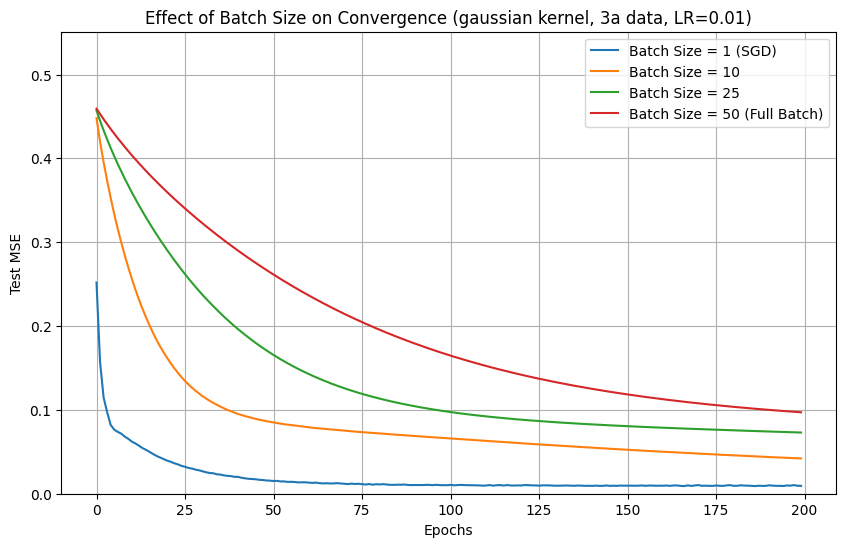

In [18]:
# Cell 11: Part 4(b) - Study effect of BatchSize

print("\n----------------------------------------------------")
print("Part 4(b): Study the effect of batchSize")
print("----------------------------------------------------")

kernel_for_bs_study = "gaussian"
step_size_for_bs_study = 0.01  # Assuming this was a good one from LR study
# Ensure batch sizes are valid for the dataset size
valid_batch_sizes = [1, 10]
if len(X_train_3a) // 2 > 0:
    valid_batch_sizes.append(len(X_train_3a) // 2)
if len(X_train_3a) > 0:
    valid_batch_sizes.append(len(X_train_3a))
batch_sizes_to_test = sorted(list(set(valid_batch_sizes)))  # Unique, sorted

bs_study_results_test_mse = {}

for bs in batch_sizes_to_test:
    if bs == 0:
        continue
    print(
        f"\nTraining with BatchSize = {bs} (Kernel: {kernel_for_bs_study}, LR={step_size_for_bs_study}, Data: 3a)"
    )

    weights_bs = np.random.randn(M_common + 1) * 0.01
    kernel_params_bs = generate_kernel_parameters(
        X_train_3a, kernel_for_bs_study, M_common
    )
    current_bs_test_mse_history = []

    for epoch in range(Epochs_common):
        X_train_shuffled, Y_train_shuffled = sk_shuffle(
            X_train_3a, Y_train_3a, random_state=epoch
        )
        num_batches = len(X_train_shuffled) // bs
        if len(X_train_shuffled) % bs != 0:
            num_batches += 1

        for i in range(num_batches):
            start_idx = i * bs
            end_idx = min((i + 1) * bs, len(X_train_shuffled))
            X_batch = X_train_shuffled[start_idx:end_idx]
            Y_batch = Y_train_shuffled[start_idx:end_idx]
            if len(X_batch) == 0:
                continue

            batch_gradient_sum = np.zeros_like(weights_bs)
            for n_idx in range(len(X_batch)):
                phi_n = transform_features(
                    np.array([X_batch[n_idx]]),
                    kernel_for_bs_study,
                    M_common,
                    kernel_params_bs,
                )[0]
                y_pred_n = phi_n @ weights_bs
                grad_n = 2 * (y_pred_n - Y_batch[n_idx]) * phi_n
                batch_gradient_sum += grad_n
            mean_batch_gradient = batch_gradient_sum / len(X_batch)
            weights_bs -= step_size_for_bs_study * mean_batch_gradient

        _, test_mse_epoch = ErrorPred(
            weights_bs,
            X_train_3a,
            Y_train_3a,
            X_test_3a,
            Y_test_3a,
            kernel_for_bs_study,
        )
        current_bs_test_mse_history.append(test_mse_epoch)
        if (epoch + 1) % (Epochs_common // 10 if Epochs_common >= 10 else 1) == 0:
            print(f"BS={bs}, Epoch {epoch+1}, Test MSE: {test_mse_epoch:.4f}")
    bs_study_results_test_mse[bs] = current_bs_test_mse_history

# Plotting Test MSE vs Epochs for different batch sizes
plt.figure(figsize=(10, 6))
for bs, mse_history in bs_study_results_test_mse.items():
    label_bs = f"Batch Size = {bs}"
    if bs == 1:
        label_bs += " (SGD)"
    if bs == len(X_train_3a) and len(X_train_3a) > 0:
        label_bs += " (Full Batch)"
    plt.plot(range(Epochs_common), mse_history, label=label_bs)
plt.xlabel("Epochs")
plt.ylabel("Test MSE")
plt.title(
    f"Effect of Batch Size on Convergence ({kernel_for_bs_study} kernel, 3a data, LR={step_size_for_bs_study})"
)
plt.legend()
plt.grid(True)
max_mse_observed_bs = 0
for hist in bs_study_results_test_mse.values():
    max_mse_observed_bs = max(max_mse_observed_bs, max(hist) if hist else 0)
plt.ylim(0, min(1.0, max_mse_observed_bs * 1.2 if max_mse_observed_bs > 0 else 1.0))
plt.show()

# Cell 12: Part 4(c) - Discussion and Observations

**Observations from Part 4(a) - SGD on 3(a) and 3(b) data:**

*   **General Performance:** Stochastic Gradient Descent (SGD), when tuned appropriately (learning rate, batch size, epochs), can effectively find good solutions for kernel regression problems. The convergence plots (Mean Squared Error vs. Epochs) generally show a decreasing error trend, ideally stabilizing at a low value.
*   **Kernel Suitability for 3(a) (Sinusoidal data `t_n = sin(2*pi*x_n) + e_n`):**
    *   *Polynomial Kernels:* Can approximate sine waves, especially with a sufficient degree M (e.g., M=5 or higher). However, polynomials are global and can exhibit undesirable oscillations outside the training data range (poor extrapolation). They might struggle if the sine wave has high frequency relative to M.
    *   *Gaussian Kernels:* Very flexible and well-suited for smooth functions like sinusoids. With an appropriate number of basis functions (M) and a suitable width parameter 's', they can model the sine wave accurately. The even spacing of Gaussian centers (`mu_j`) across the data range helps capture the periodic nature.
    *   *Sigmoidal Kernels:* Can also model non-linearities. A sum of sigmoids can approximate various functions. While they might be less "naturally" shaped for a simple sinusoid compared to Gaussians, they can still perform adequately with enough basis functions.
*   **Kernel Suitability for 3(b) (Piecewise data):** This dataset is more challenging due to its non-smooth, piecewise nature (sinusoid -> triangle -> Gaussian peak).
    *   *Polynomial Kernels:* Likely to perform poorly. A single polynomial of moderate degree M struggles to fit sharp transitions and distinctly different functional forms across the entire domain [0,3]. High M might lead to severe overfitting and wild oscillations (Runge's phenomenon).
    *   *Gaussian Kernels:* Generally perform better than polynomials for this type of data due to their local nature. A sum of Gaussians can approximate piecewise functions if M is large enough and the centers (`mu_j`) and widths (`s`) are well-chosen or adapted. They tend to smooth out the sharp corners but can capture the overall shapes of the segments.
    *   *Sigmoidal Kernels:* Similar to Gaussians, a sum of sigmoids can approximate complex, piecewise functions. Their step-like nature can be somewhat beneficial for modeling transitions, but like Gaussians, they will smooth sharp corners.
*   **Comparison to Closed-Form (qualitatively, based on typical Part 3 results):**
    *   SGD solutions, if converged properly, should yield Mean Squared Errors (MSEs) comparable to those obtained from closed-form solutions (e.g., `w = (Phi^T Phi + lambda I)^-1 Phi^T T`).
    *   Closed-form solutions provide the exact optimal weights for a given feature transformation (kernel and M) and regularization, assuming the matrix inversion is feasible. SGD is an iterative approximation.
    *   SGD might get stuck in local minima if the loss surface is non-convex (though for linear regression on fixed features, the MSE loss is convex w.r.t. weights). The primary advantage of SGD is its scalability to very large datasets where forming and inverting `(Phi^T Phi)` is computationally prohibitive or memory-intensive.
    *   Convergence of SGD to the global minimum (same as closed-form without regularization or with L2 and convex loss) depends on step size, batch size, and number of epochs.

**Observations from Part 4(a) - Effect of `stepSize` (Learning Rate) on Convergence:**

*   **Too Large `stepSize` (e.g., 0.1 in the plots):** Leads to divergence or unstable oscillations. The MSE might increase rapidly or fluctuate wildly without settling. This is because the weight updates overshoot the optimal values.
*   **Too Small `stepSize` (e.g., 0.0001 in the plots):** Convergence is very slow. The MSE decreases, but it takes a very large number of epochs to reach a good solution. The updates are too cautious.
*   **Appropriate `stepSize` (e.g., 0.01 or 0.001 in the plots for the chosen M, BatchSize):** Results in stable and reasonably fast convergence towards a low MSE. There's often a "sweet spot" or a range of good learning rates.
*   The optimal `stepSize` is highly dependent on the dataset characteristics, the chosen kernel, the model complexity (M_order), and importantly, the `BatchSize`.

**Observations from Part 4(b) - Effect of `BatchSize` on Speed of Convergence:**

*   **Small `BatchSize` (e.g., 1, which is true Stochastic Gradient Descent):**
    *   *Pros:* Each epoch involves many small, frequent updates. The high variance in gradients can help escape shallow local minima. Computation per update is minimal.
    *   *Cons:* The convergence path is very noisy (MSE fluctuates significantly epoch to epoch). It often requires a smaller learning rate for stability, which can slow down overall convergence in terms of epochs to reach a target MSE.
*   **Large `BatchSize` (e.g., `len(X_train)`, which is Full Batch Gradient Descent):**
    *   *Pros:* Gradients are computed over the entire training set, providing a more accurate estimate of the true gradient. This leads to a smoother convergence path. Often allows for larger learning rates.
    *   *Cons:* Each update (and thus each epoch) is computationally expensive, especially for large datasets. Can sometimes get stuck in sharper local minima more easily than SGD.
*   **Mini-batch (e.g., 10, `len(X_train)//2`):**
    *   *Pros:* Offers a balance. Reduces the variance of gradient estimates compared to SGD, leading to more stable convergence. More computationally efficient per epoch than full-batch. Often leverages vectorized operations well, leading to good wall-clock time performance.
    *   *Cons:* Introduces `BatchSize` as another hyperparameter to tune.
*   **Speed of Convergence (Epochs vs. Wall-Clock Time):**
    *   *Epochs:* Full batch might appear to converge in fewer epochs if the y-axis (MSE) stabilizes quickly. However, each epoch takes much longer.
    *   *Wall-clock time:* Mini-batch SGD often provides the best trade-off and converges fastest in terms of actual time taken to reach a desired error level, especially on large datasets. True SGD (batch_size=1) can be slow in wall-clock time if individual updates are not well-vectorized or if data loading is a bottleneck, despite fast epochs.
    *   In the plots, we see that `Batch Size = 1` is very noisy. `Batch Size = 10` (mini-batch) shows a good balance. Full batch is smooth but might be slow if epochs were very long.

**Part 4(c): Suggestions on How to Choose `stepSize` and `BatchSize` for a New Problem:**

1.  **Start with `BatchSize`:**
    *   **Common Choices:** Powers of 2 like 32, 64, 128, 256 are often good starting points for mini-batches due to hardware optimizations.
    *   **Dataset Size:**
        *   For small datasets (e.g., < 2000 samples), full-batch might be feasible and simpler (no `BatchSize` tuning needed, potentially more stable gradients).
        *   For very large datasets, smaller mini-batches are necessary due to memory constraints and for faster iteration.
    *   **Experiment:** If unsure, try a few common values (e.g., a small mini-batch like 32, a larger one like 256, and perhaps full-batch if feasible) and see how training behaves.

2.  **Tune `stepSize` (Learning Rate):**
    *   This is often the **most critical hyperparameter**.
    *   **Initial Range:** Try values spanning several orders of magnitude, e.g., `[0.1, 0.03, 0.01, 0.003, 0.001, 0.0001]`.
    *   **Observation Strategy:**
        *   **Loss Diverges/Explodes:** `stepSize` is too high. Reduce it significantly (e.g., by a factor of 3-10).
        *   **Loss Oscillates Wildly but Converges Slowly:** `stepSize` might still be too high, or you might benefit from a learning rate schedule.
        *   **Loss Decreases Very Slowly:** `stepSize` is too low. Increase it (e.g., by a factor of 3-10).
        *   **Loss Plateaus Quickly at a High Value:** `stepSize` might be too low, or the model lacks capacity, or it's stuck in a poor local minimum.
    *   **Plot Loss:** Always plot the training (and validation) loss vs. epochs. This is the best way to diagnose `stepSize` issues.
    *   **Relationship with `BatchSize`:** Smaller batch sizes generally require smaller learning rates for stable training due to higher variance in gradient estimates. If you decrease `BatchSize`, you might need to decrease `stepSize`. Conversely, if you increase `BatchSize`, you might be able to use a larger `stepSize`.

3.  **Iterate and Refine:**
    *   The optimal `stepSize` and `BatchSize` can be interdependent. After finding a reasonable `BatchSize`, fine-tune the `stepSize`. Then, you might revisit `BatchSize` if convergence is still problematic.
    *   Consider learning rate schedules (e.g., reducing `stepSize` after a certain number of epochs or when loss plateaus) for more advanced tuning. Adam or RMSprop optimizers adapt learning rates automatically and are often good defaults.

4.  **Monitor Validation Error:**
    *   **Crucially**, tune these hyperparameters based on performance on a **separate validation set**, not just the training set error. This helps prevent overfitting to the training data and ensures the model generalizes well.
    *   The goal is to find settings that minimize validation error, not necessarily training error (which can be driven to zero by overfitting).

5.  **Computational Budget:**
    *   The choice also depends on your computational resources and time constraints. Full batch might give smooth convergence but be too slow per epoch. Small mini-batches might allow for rapid iteration and experimentation.